# **model2**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

# โหลดชุดข้อมูล
file_path = "/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
df = pd.read_csv(file_path)

# แสดงตัวอย่างข้อมูล
print(df.head())

# ตรวจสอบคอลัมน์
print(df.columns)

# คอลัมน์ข้อความและฉลาก
text_column = "tweet"
label_column = "class"

# ลบค่าที่หายไป
df = df.dropna(subset=[text_column, label_column])

# แปลง labels เป็นค่าตัวเลข
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

# บันทึก LabelEncoder
with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# แบ่งชุดข้อมูล train และ test
X_train, X_test, y_train, y_test = train_test_split(df[text_column], df[label_column], test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# บันทึก Tokenizer
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# แปลงข้อความเป็นลำดับตัวเลข
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# เติม padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding="post", truncating="post")

# สร้างโมเดล LSTM
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ฝึกโมเดล
epochs = 20
batch_size = 32

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# บันทึกโมเดล
model.save("/content/hate_speech_modelv2.h5")
print("Model saved successfully.")

# ประเมินผล
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")



   class                                              tweet
0      2  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Index(['class', 'tweet'], dtype='object')
Epoch 1/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8181 - loss: 0.5404 - val_accuracy: 0.8939 - val_loss: 0.3191
Epoch 2/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9133 - loss: 0.2795 - val_accuracy: 0.8933 - val_loss: 0.3255
Epoch 3/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9312 - loss: 0.2121 - val_accuracy: 0.8961 - val_loss: 0.3574
Epoch 4/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9519 - loss: 0.1462 - val_accuracy: 0.8905 - val_loss: 0.3961
Epoch 5/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9683 - los

Model saved successfully.
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8735 - loss: 1.3462
Test Accuracy: 0.8713


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# โหลดโมเดลและออบเจ็กต์ที่บันทึกไว้
loaded_model = keras.models.load_model("/content/hate_speech_modelv2.h5")

with open("/content/tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

with open("/content/label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

# Mapping คลาสเป็นชื่อที่อ่านง่าย
class_mapping = {
    0: "0 - Hate Speech",
    1: "1 - Offensive Language",
    2: "2 - Neither"
}

# ฟังก์ชันทำนายข้อความใหม่
def predict_text(text):
    sequence = loaded_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100, padding="post", truncating="post")  # max_length = 100 ตามที่ใช้ตอนเทรน
    prediction = loaded_model.predict(padded)
    predicted_class = np.argmax(prediction)

    # ตรวจสอบว่าคลาสที่ทำนายอยู่ใน class_mapping หรือไม่
    return class_mapping.get(predicted_class, "Unknown")

# ทดสอบการทำนาย
sample_text = " "
print(f"Prediction: {predict_text(sample_text)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Prediction: 1 - Offensive Language


In [ ]:
pip install googletrans==4.0.0-rc1


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from googletrans import Translator

# โหลดโมเดลและออบเจ็กต์ที่บันทึกไว้
loaded_model = keras.models.load_model("/content/hate_speech_modelv2.h5")

with open("/content/tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

with open("/content/label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

# Mapping คลาสเป็นชื่อที่อ่านง่าย
class_mapping = {
    0: "0 - Hate Speech",
    1: "1 - Offensive Language",
    2: "2 - Neither"
}

# ดัดแปลงคำให้หยาบและเป็น Hate Speech มากขึ้น
hate_speech_replacements = {
    "stupid": "fucking dumbass",
    "bad": "fucking garbage",
    "annoying": "goddamn annoying",
    "idiot": "brain-dead motherfucker",
    "fool": "worthless piece of shit",
    "weak": "fucking pathetic",
    "ugly": "disgusting as fuck",
    "hate": "fucking despise",
    "loser": "absolute failure",
    "trash": "fucking human garbage",
    "disgusting": "makes me wanna puke",
    "worthless": "shouldn’t even exist",
    "dumb": "dumb as a rock",
    "failure": "walking disappointment",
    "lazy": "useless sack of shit"
}

# ฟังก์ชันทำนายข้อความใหม่
def predict_text(text):
    translator = Translator()
    translated_text = translator.translate(text, src="auto", dest="en").text
    #print(f"Translated Text (before modification): {translated_text}")

    # เพิ่มระดับความรุนแรงของ Hate Speech
    for word, replacement in hate_speech_replacements.items():
        translated_text = translated_text.replace(word, replacement)

    print(f"Translated Text (after modification): {translated_text}")

    # แปลงเป็นลำดับและทำ Padding
    sequence = loaded_tokenizer.texts_to_sequences([translated_text])
    padded = pad_sequences(sequence, maxlen=100, padding="post", truncating="post")
    prediction = loaded_model.predict(padded)
    predicted_class = np.argmax(prediction)

    return class_mapping.get(predicted_class, "Unknown")

# รับข้อความจากผู้ใช้
sample_text = input("Enter text: ")
print(f"Prediction: {predict_text(sample_text)}")


Enter text: หน้าเหมือนผนังมดลูก
Translated Text (after modification): The face is like the uterus wall.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Prediction: 2 - Neither


# **model version3**



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler  # สำหรับ Oversampling
import re
import pickle

# โหลดชุดข้อมูล
file_path = "/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
df = pd.read_csv(file_path)

# คอลัมน์ข้อความและฉลาก
text_column = "tweet"
label_column = "class"

# ลบค่าที่หายไป
df = df.dropna(subset=[text_column, label_column])

# ทำความสะอาดข้อความ
def clean_text(text):
    text = text.lower()  # แปลงเป็นตัวพิมพ์เล็ก
    text = re.sub(r"http\S+|www\S+", "", text)  # ลบลิงก์
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # ลบตัวเลขและอักขระพิเศษ
    text = re.sub(r"\s+", " ", text).strip()  # ลบช่องว่างเกินและ trim
    return text

df[text_column] = df[text_column].apply(clean_text)

# แปลง labels เป็นค่าตัวเลข
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

# บันทึก LabelEncoder
with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# ปรับสมดุลข้อมูลโดยใช้ Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[[text_column]], df[label_column])

# คืนค่า DataFrame ที่ปรับสมดุลแล้ว
df_balanced = pd.DataFrame({text_column: X_resampled[text_column], label_column: y_resampled})

# แบ่งชุดข้อมูล train และ test
X_train, X_test, y_train, y_test = train_test_split(df_balanced[text_column], df_balanced[label_column], test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# บันทึก Tokenizer
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# แปลงข้อความเป็นลำดับตัวเลข
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# เติม padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding="post", truncating="post")

# สร้างโมเดล LSTM
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ฝึกโมเดล
epochs = 20
batch_size = 32

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# บันทึกโมเดล
model.save("/content/hate_speech_modelv3.h5")
print("Model saved successfully.")

# ประเมินผล
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1440/1440 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.7987 - loss: 0.4835 - val_accuracy: 0.9582 - val_loss: 0.1401
Epoch 2/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.9715 - loss: 0.1067 - val_accuracy: 0.9658 - val_loss: 0.1094
Epoch 3/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9845 - loss: 0.0606 - val_accuracy: 0.9723 - val_loss: 0.1038
Epoch 4/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9908 - loss: 0.0375 - val_accuracy: 0.9737 - val_loss: 0.1095
Epoch 5/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.9915 - loss: 0.0296 - val_accuracy: 0.9793 - val_loss: 0.0967
Epoch 6/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9950 - loss: 0.0181 - val_accuracy: 0.9797 - val_loss: 0.1130
Epoch 7/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9958 - loss: 0.0159 - val_accuracy: 0.9760 - val_loss: 0.1540
Epoch 8/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9956 - loss: 0.01

Model saved successfully.
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9827 - loss: 0.1992
Test Accuracy: 0.9828


**Check bias**

🔹 การกระจายของคลาสก่อนปรับสมดุล
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


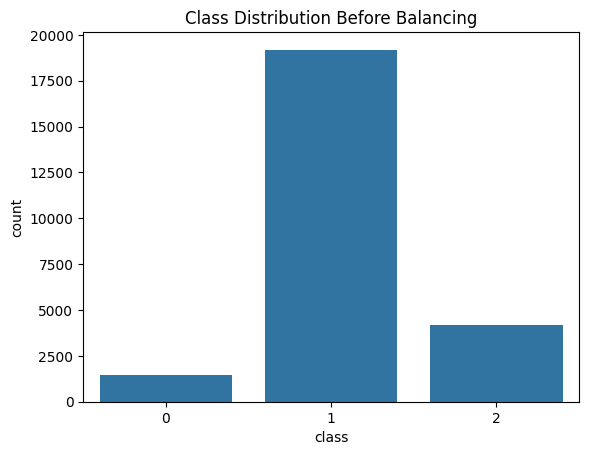


🔹 การกระจายของคลาสหลังปรับสมดุล
class
2    19190
1    19190
0    19190
Name: count, dtype: int64


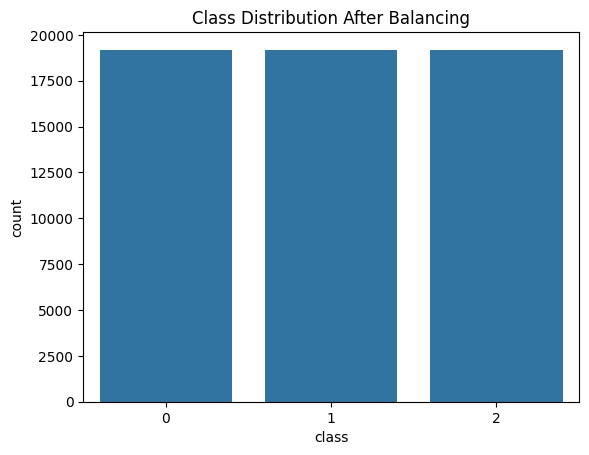


🔹 การกระจายของคลาสใน Train Set
class
1    15396
0    15341
2    15319
Name: count, dtype: int64

🔹 การกระจายของคลาสใน Test Set
class
2    3871
0    3849
1    3794
Name: count, dtype: int64


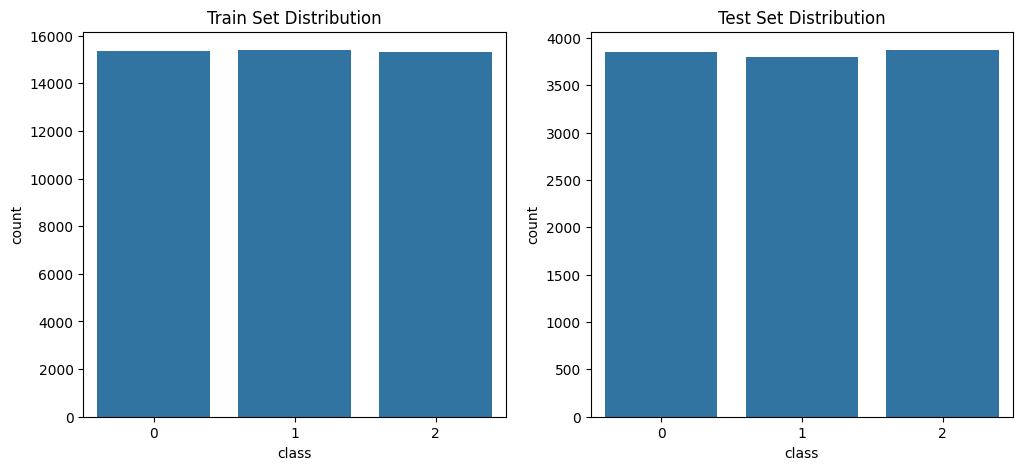

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler  # สำหรับ Oversampling
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดชุดข้อมูล
file_path = "/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
df = pd.read_csv(file_path)

# คอลัมน์ข้อความและฉลาก
text_column = "tweet"
label_column = "class"

# ลบค่าที่หายไป
df = df.dropna(subset=[text_column, label_column])

# ตรวจสอบการกระจายของคลาสก่อนปรับสมดุล
print("🔹 การกระจายของคลาสก่อนปรับสมดุล")
print(df[label_column].value_counts())

# แสดงกราฟก่อนปรับสมดุล
sns.countplot(x=df[label_column])
plt.title("Class Distribution Before Balancing")
plt.show()

# ทำความสะอาดข้อความ
def clean_text(text):
    text = text.lower()  # แปลงเป็นตัวพิมพ์เล็ก
    text = re.sub(r"http\S+|www\S+", "", text)  # ลบลิงก์
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # ลบตัวเลขและอักขระพิเศษ
    text = re.sub(r"\s+", " ", text).strip()  # ลบช่องว่างเกินและ trim
    return text

df[text_column] = df[text_column].apply(clean_text)

# แปลง labels เป็นค่าตัวเลข
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])


# ปรับสมดุลข้อมูลโดยใช้ Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[[text_column]], df[label_column])

# คืนค่า DataFrame ที่ปรับสมดุลแล้ว
df_balanced = pd.DataFrame({text_column: X_resampled[text_column], label_column: y_resampled})

# ตรวจสอบการกระจายของคลาสหลังปรับสมดุล
print("\n🔹 การกระจายของคลาสหลังปรับสมดุล")
print(df_balanced[label_column].value_counts())

# แสดงกราฟหลังปรับสมดุล
sns.countplot(x=df_balanced[label_column])
plt.title("Class Distribution After Balancing")
plt.show()

# แบ่งชุดข้อมูล train และ test
X_train, X_test, y_train, y_test = train_test_split(df_balanced[text_column], df_balanced[label_column], test_size=0.2, random_state=42)

# ตรวจสอบการกระจายของ train-test set
print("\n🔹 การกระจายของคลาสใน Train Set")
print(pd.Series(y_train).value_counts())

print("\n🔹 การกระจายของคลาสใน Test Set")
print(pd.Series(y_test).value_counts())

# แสดงกราฟ Train-Test Split
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Train Set Distribution")

sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title("Test Set Distribution")

plt.show()


test

In [ ]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=a8bb855234c407c4b8b05a5945168575d50f50b2960536052c65111979369b9f
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from googletrans import Translator

# โหลดโมเดลและออบเจ็กต์ที่บันทึกไว้
loaded_model = keras.models.load_model("/content/hate_speech_modelv3.h5")

with open("/content/tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

with open("/content/label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

# Mapping คลาสเป็นชื่อที่อ่านง่าย
class_mapping = {
    0: "0 - Hate Speech",
    1: "1 - Offensive Language",
    2: "2 - Neither"
}

# ดัดแปลงคำให้หยาบและเป็น Hate Speech มากขึ้น
hate_speech_replacements = {
    "stupid": "fucking dumbass",
    "bad": "fucking garbage",
    "annoying": "goddamn annoying",
    "idiot": "brain-dead motherfucker",
    "fool": "worthless piece of shit",
    "weak": "fucking pathetic",
    "ugly": "disgusting as fuck",
    "hate": "fucking despise",
    "loser": "absolute failure",
    "trash": "fucking human garbage",
    "disgusting": "makes me wanna puke",
    "worthless": "shouldn’t even exist",
    "dumb": "dumb as a rock",
    "failure": "walking disappointment",
    "lazy": "useless sack of shit"
}

# ฟังก์ชันทำนายข้อความใหม่
def predict_text(text):
    translator = Translator()
    translated_text = translator.translate(text, src="auto", dest="en").text
    #print(f"Translated Text (before modification): {translated_text}")

    # เพิ่มระดับความรุนแรงของ Hate Speech
    for word, replacement in hate_speech_replacements.items():
        translated_text = translated_text.replace(word, replacement)

    print(f"Translated Text (after modification): {translated_text}")

    # แปลงเป็นลำดับและทำ Padding
    sequence = loaded_tokenizer.texts_to_sequences([translated_text])
    padded = pad_sequences(sequence, maxlen=100, padding="post", truncating="post")
    prediction = loaded_model.predict(padded)
    predicted_class = np.argmax(prediction)

    return class_mapping.get(predicted_class, "Unknown")

# รับข้อความจากผู้ใช้
sample_text = input("Enter text: ")
print(f"Prediction: {predict_text(sample_text)}")


Enter text: ฉันรักคุณ
Translated Text (after modification): I love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Prediction: 1 - Offensive Language


# test **model2**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pickle

# โหลดชุดข้อมูล
file_path = "/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
df = pd.read_csv(file_path)

# ตรวจสอบคอลัมน์
text_column = "tweet"
label_column = "class"

# ลบค่าที่หายไป
df = df.dropna(subset=[text_column, label_column])

# แปลง labels เป็นค่าตัวเลข
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

# บันทึก LabelEncoder
with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# แบ่งชุดข้อมูล train และ test
X_train, X_test, y_train, y_test = train_test_split(df[text_column], df[label_column], test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# บันทึก Tokenizer
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# แปลงข้อความเป็นลำดับตัวเลข
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# เติม padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding="post", truncating="post")

# สร้างโมเดล LSTM
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ฝึกโมเดล
epochs = 20
batch_size = 32

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# บันทึกโมเดล
model.save("/content/hate_speech_modelv2.h5")
print("Model saved successfully.")

# ประเมินผล
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# 🔹 **คำนวณ Precision, Recall, F1-score**
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)  # เลือก class ที่มีค่าความน่าจะเป็นสูงสุด

# แปลง Label เป็นชื่อคลาสเดิม
target_names = label_encoder.inverse_transform([0, 1, 2])  # ให้แน่ใจว่าคลาสเรียงถูกต้อง


In [ ]:
from sklearn.metrics import classification_report

# 🔹 ทำนายผล
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

# 🔹 แปลงชื่อคลาสเป็นสตริง
class_names = list(map(str, label_encoder.classes_))

# 🔹 สร้างรายงานผลลัพธ์
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)

# 🔹 แสดงผลลัพธ์
print("\n" + "="*50)
print(" 📊 Classification Report ")
print("="*50)
print(report)
print("="*50)


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

 📊 Classification Report 
              precision    recall  f1-score   support

           0     0.2634    0.3724    0.3086       290
           1     0.9198    0.9066    0.9131      3832
           2     0.8455    0.7796    0.8112       835

    accuracy                         0.8539      4957
   macro avg     0.6762    0.6862    0.6776      4957
weighted avg     0.8689    0.8539    0.8606      4957



# **test model3**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler  # สำหรับ Oversampling
import re
import pickle

# โหลดชุดข้อมูล
file_path = "/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv"
df = pd.read_csv(file_path)

# คอลัมน์ข้อความและฉลาก
text_column = "tweet"
label_column = "class"

# ลบค่าที่หายไป
df = df.dropna(subset=[text_column, label_column])

# ทำความสะอาดข้อความ
def clean_text(text):
    text = text.lower()  # แปลงเป็นตัวพิมพ์เล็ก
    text = re.sub(r"http\S+|www\S+", "", text)  # ลบลิงก์
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # ลบตัวเลขและอักขระพิเศษ
    text = re.sub(r"\s+", " ", text).strip()  # ลบช่องว่างเกินและ trim
    return text

df[text_column] = df[text_column].apply(clean_text)

# แปลง labels เป็นค่าตัวเลข
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

# บันทึก LabelEncoder
with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# ปรับสมดุลข้อมูลโดยใช้ Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[[text_column]], df[label_column])

# คืนค่า DataFrame ที่ปรับสมดุลแล้ว
df_balanced = pd.DataFrame({text_column: X_resampled[text_column], label_column: y_resampled})

# แบ่งชุดข้อมูล train และ test
X_train, X_test, y_train, y_test = train_test_split(df_balanced[text_column], df_balanced[label_column], test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# บันทึก Tokenizer
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# แปลงข้อความเป็นลำดับตัวเลข
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# เติม padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding="post", truncating="post")

# สร้างโมเดล LSTM
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ฝึกโมเดล
epochs = 20
batch_size = 32

model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))

# บันทึกโมเดล
model.save("/content/hate_speech_modelv3.h5")
print("Model saved successfully.")

from sklearn.metrics import classification_report

# 🔹 ทำนายผล
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

# 🔹 แปลงชื่อคลาสเป็นสตริง
class_names = list(map(str, label_encoder.classes_))

# 🔹 สร้างรายงานผลลัพธ์
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)

# 🔹 แสดงผลลัพธ์
print("\n" + "="*50)
print(" 📊 Classification Report ")
print("="*50)
print(report)
print("="*50)





Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1440/1440 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.7940 - loss: 0.4888 - val_accuracy: 0.9600 - val_loss: 0.1335
Epoch 2/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.9709 - loss: 0.1079 - val_accuracy: 0.9696 - val_loss: 0.1080
Epoch 3/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9842 - loss: 0.0567 - val_accuracy: 0.9713 - val_loss: 0.1096
Epoch 4/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9899 - loss: 0.0352 - val_accuracy: 0.9739 - val_loss: 0.1088
Epoch 5/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.9901 - loss: 0.0316 - val_accuracy: 0.9756 - val_loss: 0.1220
Epoch 6/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9933 - loss: 0.0237 - val_accuracy: 0.9796 - val_loss: 0.1232
Epoch 7/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9801 - val_loss: 0.1228
Epoch 8/20
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9959 - loss: 0.01

Model saved successfully.
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

 📊 Classification Report 
              precision    recall  f1-score   support

           0     0.9814    1.0000    0.9906      3849
           1     0.9956    0.9449    0.9696      3794
           2     0.9659    0.9959    0.9807      3871

    accuracy                         0.9805     11514
   macro avg     0.9810    0.9803    0.9803     11514
weighted avg     0.9809    0.9805    0.9803     11514

